Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#% matplotlib inline

In [2]:
import pandas as pd
import nltk
#from bs4 import BeautifulSoup4
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

Loading data

In [3]:
df_train = pd.read_csv('Football-Scenarios-DFE-832307.csv', header=0, encoding = 'unicode_escape')

In [4]:
df_train.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,antecedent,antecedent:confidence,orig_antecedent,antecedent_gold,option1,option2,option3,option4,option5
0,831005673,False,finalized,5,11/20/15 20:20,kick a field goal,0.8092,It is first down and 10. The ball is on your o...,NaN,punt,kick a field goal,run,pass,kneel down
1,831005674,False,finalized,5,11/18/15 21:59,kick a field goal,1.0000,It is second down and inches. The ball is on y...,NaN,punt,kick a field goal,run,pass,kneel down
2,831005675,False,finalized,5,11/20/15 22:43,kick a field goal,0.6211,It is second down and inches. The ball is on y...,NaN,punt,kick a field goal,run,pass,kneel down
3,831005676,False,finalized,5,11/19/15 7:41,kick a field goal,0.8073,It is second down and inches. The ball is on y...,NaN,punt,kick a field goal,run,pass,kneel down
4,831005677,False,finalized,5,11/21/15 8:01,kick a field goal,1.0000,It is second down and inches. The ball is on y...,NaN,punt,kick a field goal,run,pass,kneel down


Input: orig_antecedent. Ouput: antecedent

In [5]:
from io import StringIO

col = ['antecedent', 'orig_antecedent']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['orig_antecedent'])]

df_train.columns = ['antecedent', 'orig_antecedent']

df_train['category_id'] = df_train['antecedent'].factorize()[0]

category_id_df_train = df_train[['antecedent', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'antecedent']].values)

df_train.head()

,antecedent,orig_antecedent,category_id
0,kick a field goal,It is first down and 10. The ball is on your o...,0
1,kick a field goal,It is second down and inches. The ball is on y...,0
2,kick a field goal,It is second down and inches. The ball is on y...,0
3,kick a field goal,It is second down and inches. The ball is on y...,0
4,kick a field goal,It is second down and inches. The ball is on y...,0


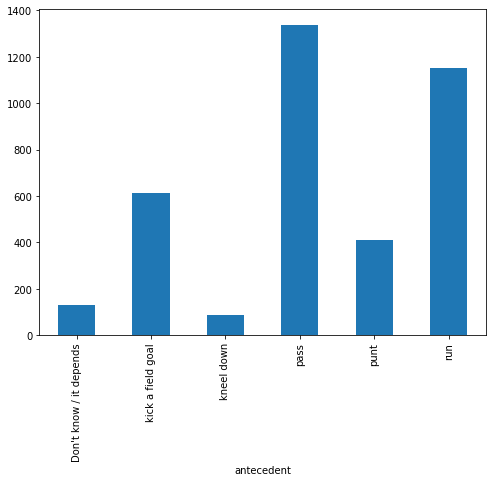

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_train.groupby('antecedent').orig_antecedent.count().plot.bar(ylim=0)
plt.show()

In [7]:
df_train["category_id"].value_counts()

1    1339
3    1152
0     612
5     411
4     130
2      86
Name: category_id, dtype: int64

Text Representation

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize


For each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf.

In [9]:
vectorizer = TfidfVectorizer(min_df =5, ngram_range = (1, 3), strip_accents = 'unicode',
                            lowercase = True, stop_words = 'english', 
                             tokenizer = word_tokenize)

features = vectorizer.fit_transform(df_train.orig_antecedent).toarray()

labels = df_train.category_id
features.shape


(3730, 157)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1,
                                                   random_state = 0)

Classification with Logistic Regression

In [11]:
lr = LogisticRegression(C = 10, class_weight = {0:0.07 , 1:1})
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight={0: 0.07, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
y_pred_train1 = lr.predict(X_train)

In [13]:
print(f1_score(y_train, y_pred_train1, pos_label = 'positive', average = 'micro'))



0.7578194816800715


In [14]:
cm1 = confusion_matrix(y_train, y_pred_train1) 
cm1


array([[ 221,  109,    6,  153,    6,   51],
       [   9, 1017,   22,  117,    5,   38],
       [   1,   51,   18,    4,    0,    3],
       [   1,  143,    3,  868,    1,   22],
       [   2,   26,    0,   12,   64,   11],
       [   1,    7,    5,    4,    0,  356]])

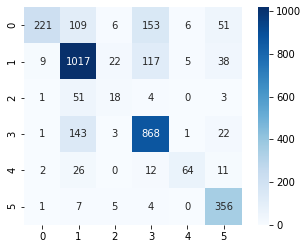

In [15]:
sns.heatmap(cm1, cmap="Blues", annot=True, square=True, fmt=".0f")

In [16]:
print(classification_report(y_train, y_pred_train1))

              precision    recall  f1-score   support

           0       0.94      0.40      0.57       546
           1       0.75      0.84      0.79      1208
           2       0.33      0.23      0.27        77
           3       0.75      0.84      0.79      1038
           4       0.84      0.56      0.67       115
           5       0.74      0.95      0.83       373

    accuracy                           0.76      3357
   macro avg       0.73      0.64      0.65      3357
weighted avg       0.77      0.76      0.74      3357



Classification with MultinomialNB

In [17]:
mnb = MultinomialNB(alpha = 0.1)
mnb.fit(X_train, y_train)


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [18]:
y_pred_train2 = mnb.predict(X_train)

In [19]:
print(f1_score(y_train, y_pred_train2, pos_label = 'positive', average = 'micro'))


0.7158176943699732


In [20]:
cm2 = confusion_matrix(y_train, y_pred_train2) 
cm2

array([[298, 121,   1, 123,   3,   0],
       [ 48, 996,  50,  91,   4,  19],
       [ 24,  27,  26,   0,   0,   0],
       [ 36, 163,   7, 824,   3,   5],
       [  4,  46,   0,  15,  47,   3],
       [ 11,  82,  20,  48,   0, 212]])

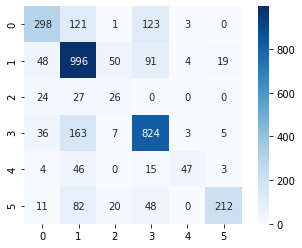

In [21]:
sns.heatmap(cm2, cmap="Blues", annot=True, square=True, fmt=".0f")

In [22]:
print(classification_report(y_train, y_pred_train2))

              precision    recall  f1-score   support

           0       0.71      0.55      0.62       546
           1       0.69      0.82      0.75      1208
           2       0.25      0.34      0.29        77
           3       0.75      0.79      0.77      1038
           4       0.82      0.41      0.55       115
           5       0.89      0.57      0.69       373

    accuracy                           0.72      3357
   macro avg       0.69      0.58      0.61      3357
weighted avg       0.73      0.72      0.71      3357



Classification with Linear SVC

In [23]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C = 5, class_weight = {0 : 0.07, 1 : 1})
svc.fit(X_train, y_train)

LinearSVC(C=5, class_weight={0: 0.07, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [24]:
y_pred_train3 = svc.predict(X_train)


In [25]:
print(f1_score(y_train, y_pred_train3, pos_label = 'positive', average = 'micro'))

0.7682454572535001


In [26]:
cm3 = confusion_matrix(y_train, y_pred_train3) 
cm3

array([[274,  86,   5, 123,   4,  54],
       [ 14, 994,  20, 134,   5,  41],
       [  1,  53,  16,   4,   0,   3],
       [  3, 137,   3, 872,   1,  22],
       [  2,  26,   0,  13,  66,   8],
       [  1,   7,   5,   3,   0, 357]])

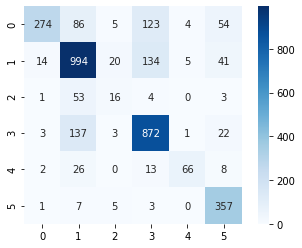

In [27]:
sns.heatmap(cm3, cmap="Blues", annot=True, square=True, fmt=".0f")

In [28]:
print(classification_report(y_train, y_pred_train3))

              precision    recall  f1-score   support

           0       0.93      0.50      0.65       546
           1       0.76      0.82      0.79      1208
           2       0.33      0.21      0.25        77
           3       0.76      0.84      0.80      1038
           4       0.87      0.57      0.69       115
           5       0.74      0.96      0.83       373

    accuracy                           0.77      3357
   macro avg       0.73      0.65      0.67      3357
weighted avg       0.78      0.77      0.76      3357

